# Model building

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from zipfile import ZipFile
import os
import sys
limit = None


def plot_PCA(data, y=None):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        data.PC1.values, 
        data.PC2.values, 
        marker='.', 
        linewidths=0.5,
        c=y,
    )
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.show()

def confusion(y_test, y_hat):
        cm = confusion_matrix(y_test, y_hat)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

        # Bonus: Normalise by row
        sns.heatmap(cm/cm.sum(axis=1, keepdims=True), annot=True, fmt='.3f')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()
        
        print(classification_report(y_test, y_hat, digits=3))

def plot_tsne(data, y=None):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        data.TSNE1.values, 
        data.TSNE2.values, 
        marker='.', 
        linewidths=0.5,
        c=y
    )
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.show()

def plot_coloured_tsne(labels):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        labels.TSNE1.values, 
        labels.TSNE2.values, 
        marker='.', 
        linewidths=0.5,
        c=labels.ground_truth,
    )
    plt.show()

def iterate_tsnes(data, params, n_samples, y=None):
    
    df_ML_50_1 = data.iloc[:n_samples,:]
    
    for param in params:        
        tsne = TSNE(
            n_components=2, 
            perplexity=40, 
            verbose=0)
        print (param)
        tsne.set_params(**param)
        digits_tsne = tsne.fit_transform(df_ML_50_1)
        labels = pd.DataFrame()
        labels["TSNE1"] = digits_tsne[:,0]
        labels["TSNE2"] = digits_tsne[:,1]
        plot_tsne(labels)
        if y is not None:
            labels['ground_truth'] = y[:n_samples]
            plot_coloured_tsne(labels)
        
        

def compute_pca(data, n_comp, y=None, return_data=False):
    Xstandard = pd.DataFrame(
    StandardScaler().fit_transform(data),
    columns=data.columns,
    index=data.index)
    pca = PCA(n_components=n_comp)
    df_pca = pd.DataFrame(
        pca.fit_transform(Xstandard),
        columns = ['PC'+str(i+1) for i in range(n_comp)], 
        index   = data.index)
    print("Cumulative variance explained by first {} Principal Components: {}".format(pca.n_components, np.sum(pca.explained_variance_ratio_)))    # df_ML_50 = pca.fit_transform(digits.values)
    
    plot_PCA(df_pca, y)
    variance_data(pca)
    
    if return_data==True: return pca, df_pca


def label_encoder(data, label):
    le = LabelEncoder()
    le.fit(data.loc[:, label].unique())
    response = le.transform(data.loc[:, label])
    featmatrix = data.drop(label, axis=1)
    classes = le.classes_
    return featmatrix, response, classes
    
def clean3(zippath, filenames):
    
    # amino-acid letters
    aa = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
    
    # files to dataframe
    with ZipFile(zippath, 'r').open(filenames[0]) as file1:
        df_seq = pd.read_csv(file1)        
    with ZipFile(zippath, 'r').open(filenames[1]) as file2:
        df_dup = pd.read_csv(file2)
    
    # merge the dataframes
    df_merge = df_dup.merge(df_seq,how='inner',on='structureId')
    df_merge.rename({'macromoleculeType_x':'macromoleculeType',
                                            'residueCount_y':'residueCount'},axis=1,inplace=True)
    
    # clean the columns
    df_merge.drop(['macromoleculeType_y','residueCount_x'],axis=1,inplace=True)
    df_merge_protein = df_merge[df_merge.macromoleculeType=='Protein']
    df_merge_proteins = df_merge_protein[df_merge_protein.chainId=='A']
    df_merge_proteins2 = df_merge_proteins.drop([
                         'experimentalTechnique',
                         'chainId',
                         'residueCount',
                         'macromoleculeType',
                         'crystallizationMethod',
                         'crystallizationTempK',
                         'densityMatthews',
                         'densityPercentSol',
                         'pdbxDetails',
                        # 'phValue',
                         'publicationYear',
                         'resolution'], axis=1)
    
    
    # drop na
    df_merge_proteins3 = df_merge_proteins2.dropna()
    
    # to identify the top 10 classes
    tab = df_merge_proteins2.classification.value_counts(normalize=True)
    filtered_classes = list(tab.keys()[:10])
    df_merge_proteins4 = df_merge_proteins3[df_merge_proteins3.classification.isin(filtered_classes)]
    
    # to delete unreadable amino-acid letters
    mask = df_merge_proteins4.sequence.apply(lambda x: set(x) <= set(aa))
    df_masked = df_merge_proteins4[mask]
    
    # cleansed sequences to list
    sequences = df_masked.sequence.tolist()
    
    # indexes
    indexes = df_masked.structureId
#     return sequences, indexes
    return df_masked


def variance_data(pca_object):
    # Calculate the explained variance
    exp_var = [i*100 for i in pca_object.explained_variance_ratio_]

    # Calculate the cumulative variance
    cum_var = np.cumsum(pca_object.explained_variance_ratio_*100)

    # Combine both in a data frame
    pca_var = pd.DataFrame(data={'Explained Var': exp_var,
                                 'Cumulative Var': cum_var})
    print(pca_var.head(10))

    # display both the explained and cumulative variance
    fig = plt.figure(figsize=(10,7))

    ax = sns.barplot(
            x = pca_var.index, 
            y = 'Explained Var',  data = pca_var )
    ax.set(
            xlabel = 'Principal Components', 
            ylabel = 'Explained Variance' )

    fig = plt.figure(figsize=(10,7))

    ax = sns.barplot(
            x = pca_var.index, 
            y = 'Cumulative Var',  data = pca_var )
    ax.set(
            xlabel = 'Principal Components', 
            ylabel = 'Cumulative Variance' )
        


# Instructions

Downloads:
1. 11797_16251_bundle_archive.zip (https://www.kaggle.com/shahir/protein-data-set/download do not unpack the zip)
2. descr_kaggledataset_autocorrelation.csv (https://drive.google.com/open?id=1Iz_dMTkL2zm2OKdjKdIJMourV5iqrlFQ) alternatively follow the instructions here (https://github.com/gerry883/capstone) for "Kaggle dataset to csv"

place them in the same folder.

set the path containing the two files as current directory

create a python 3 env installing sklearn

### base dataframe to work on

In [10]:
zip_file = "11797_16251_bundle_archive.zip"
file_list = ['pdb_data_seq.csv','pdb_data_no_dups.csv']

df_masked = clean3(zip_file, file_list)

df_descriptors = pd.read_csv('descr_kaggledataset_autocorrelation.csv')

df_ML = pd.merge(df_masked, df_descriptors, how='inner')

print(df_ML.shape)

print(df_ML.isnull().sum().value_counts())

print(df_ML.columns[:4])

Index(['structureId', 'classification', 'structureMolecularWeight', 'phValue'], dtype='object')

### (optional) run to save an additional version

In [11]:
df_ML1 = df_ML.drop(['sequence','classification'], axis=1)

df_ML2 = df_ML1.set_index('structureId')

df_ML2.to_csv('kaggle_dataset_for_ML.csv')

### suport vector regressor for pH regression

In [3]:
# df_towork = pd.read_csv('kaggle_dataset_for_ML.csv', index_col='structureId')

df_ML1 = df_ML.drop(['sequence','classification'], axis=1)

df_ML2 = df_ML1.set_index('structureId')

df_towork = df_ML2

y = df_towork.phValue
X = df_towork.drop('phValue',axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=123)

lr = LinearRegression()
svr = SVR(kernel='poly', verbose=True)
# lr.fit(Xtrain, ytrain)
# ypred = lr.predict(Xtest)
svr.fit(Xtrain, ytrain)
ypred = svr.predict(Xtest)

print(r2_score(ytest, ypred))


# final = pd.DataFrame()
final = pd.DataFrame(ypred, columns=['pred'])
# final['pred'] = pd.DataFrame(ytest)

final['test'] = pd.DataFrame(ytest).reset_index().phValue

print(final.describe())

plt.scatter(final.test,final.pred)

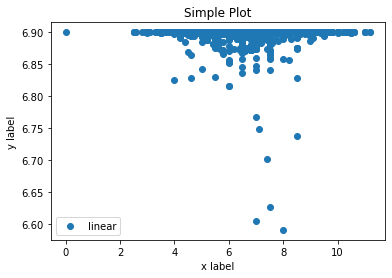

In [256]:
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.scatter(final.test,final.pred, label='linear')  # Plot some data on the axes.
# ax.plot(x, x**2, label='quadratic')  # Plot more data on the axes...
# ax.plot(x, x**3, label='cubic')  # ... and some more.
# ax.set_ylim(6.8975,6.9025)
ax.set_xlabel('x label')  # Add an x-label to the axes.
ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend()  # Add a legend.

## PCA on df_towork

In [122]:
df_ML1 = df_ML.drop(['sequence','classification'], axis=1)

df_ML2 = df_ML1.set_index('structureId')

df_towork = df_ML2

scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(df_towork),
                           columns=df_towork.columns)


pca = PCA()
ylabel = 'phValue'
pca.fit(scaled_data.drop('phValue',axis=1))
W = pca.components_    
pca_df = pd.DataFrame(
    pca.fit_transform(scaled_data.drop('phValue',axis=1)),
    columns = ['PC'+str(i+1) for i in range(scaled_data.drop('phValue',axis=1).shape[1])], 
    index   = scaled_data.drop('phValue',axis=1).index)

X = pca_df.iloc[:,:10]
y = scaled_data.phValue

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=123)

lr = LinearRegression()
svr = SVR(kernel='poly', verbose=True)
# lr.fit(Xtrain, ytrain)
# ypred = lr.predict(Xtest)
svr.fit(Xtrain, ytrain)
ypred = svr.predict(Xtest)

print(r2_score(ytest, ypred))
# plt.scatter(ypred,ytest)
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.scatter(ypred,ytest, label='linear')  # Plot some data on the axes.
# ax.plot(x, x**2, label='quadratic')  # Plot more data on the axes...
# ax.plot(x, x**3, label='cubic')  # ... and some more.
ax.set_xlim(-2,2)
ax.set_xlabel('x label')  # Add an x-label to the axes.
ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend()  # Add a legend.

variance_data(pca)

structureMolecularWeight   phValue  MoreauBrotoAuto_ResidueASA27  \
0                     -0.213679 -0.605854                     -1.323777   
1                     -0.562984 -1.551871                      1.645859   
2                     -0.546801 -1.551871                      1.645859   
3                     -0.374789 -0.290516                     -1.207775   
4                     -0.386472 -0.132846                     -1.207775   
...                         ...       ...                           ...   
55862                 -0.221065  0.576666                     -0.720569   
55863                 -0.380552 -0.605854                     -1.196175   
55864                 -0.671159  1.365013                     -0.790170   
55865                 -0.412323  0.182493                      0.021839   
55866                  0.141794 -0.211681                      0.207442   

       MoreauBrotoAuto_ResidueASA26  MoreauBrotoAuto_ResidueASA25  \
0                         -0.858152                      0.470030   
1                          2.177321                     -0.045601   
2                          2.177321                     -0.045601   
3                         -1.383522                     -0.955537   
4                         -1.383522                     -0.955537   
...                             ...                           ...   
55862                     -1.529458                      0.106055   
55863                     -1.179212                     -0.970702   
55864                     -1.689988                     -1.122358   
55865                      1.068206                     -0.394409   
55866                     -0.318188                      1.288972   

       MoreauBrotoAuto_ResidueASA24  MoreauBrotoAuto_ResidueASA23  \
0                          0.348676                      0.295320   
1                          2.074418                      2.090322   
2                          2.074418                      2.090322   
3                         -0.596730                     -0.504135   
4                         -0.596730                     -0.504135   
...                             ...                           ...   
55862                      0.783863                      0.853430   
55863                     -0.476679                     -0.368379   
55864                     -0.761801                     -0.519219   
55865                     -0.056498                      0.023807   
55866                     -0.206563                     -0.187370   

       MoreauBrotoAuto_ResidueASA22  MoreauBrotoAuto_ResidueASA21  \
0                         -0.229185                     -0.173303   
1                          0.761087                      0.704799   
2                          0.761087                      0.704799   
3                          0.516911                      0.526435   
4                          0.516911                      0.526435   
...                             ...                           ...   
55862                     -0.283447                     -0.296786   
55863                      0.544041                      0.540155   
55864                     -1.829900                     -1.751141   
55865                      0.964568                      0.979206   
55866                     -0.391970                     -0.365387   

       MoreauBrotoAuto_ResidueASA20  ...  GearyAuto_Steric19  \
0                          0.224859  ...           -1.454737   
1                          2.190561  ...           -0.062551   
2                          2.190561  ...           -0.062551   
3                         -0.430375  ...            0.071867   
4                         -0.430375  ...            0.071867   
...                             ...  ...                 ...   
55862                      0.849617  ...           -0.571419   
55863                     -0.308471  ...            0.119874   
55864                     -0.399899  ...   

## Logistic regression

In [261]:
def label_encoder(data, label):
    le = LabelEncoder()
    le.fit(data.loc[:, label].unique())
    response = le.transform(data.loc[:, label])
    featmatrix = data.drop(label, axis=1)
    return featmatrix, response
    
def lgapply(X_train, X_test, y_train, y_test):

    logreg = LogisticRegression(verbose=5)
    logreg.fit(X_train,y_train)
    ypred = logreg.predict(X_test)

    acc_score(ypred, y_test)
    
def gridsearch_logreg(X_train, X_test, y_train, y_test):
        # your code here

        # for each parameter specify a range of values you want to test
        penalty    = ['l1', 'l2']
        C_range    = 2. ** np.arange(-5, 5, step=1)
        # build a dictionary of parameters
        parameters = [{'C': C_range, 'penalty': penalty}]

        # pass the dictionary to GridSearchCV specifying that it's the LogisticRegression
        # and indicating the number of cross validation folds
        grid = GridSearchCV(LogisticRegression(), parameters, cv=5)
        grid.fit(X_train, y_train)

        # display the results
        bestC = grid.best_params_['C']
        bestP = grid.best_params_['penalty']
        print ("The best parameters are: cost=", bestC , " and penalty=", bestP, "\n")

        # use the best parameters and check the accuracy
        print("Accuracy: {0:.4f}".format(accuracy_score(y_test, grid.predict(X_test))))

In [175]:
X, y = label_encoder(df_ML,'classification')
print(y)
X1 = X.drop(['structureId','structureMolecularWeight','phValue','sequence'], axis=1)
X1

In [211]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y, test_size=0.3, random_state=123, stratify=y)
scaler = StandardScaler()
pca = PCA()
# pca.fit(X1)
# W = pca.components_
pca_df = pd.DataFrame(
    pca.fit_transform(X1),
    columns = ['PC'+str(i+1) for i in range(X1.shape[1])], 
    index   = X1.index)
scaled_data = pd.DataFrame(scaler.fit_transform(pca_df),
                           columns=pca_df.columns)
scaled_data
Xtrain, Xtest, ytrain, ytest = train_test_split(scaled_data.iloc[:,:10], y, test_size=0.3, random_state=123, stratify=y)

In [214]:
logreg = LogisticRegression(verbose=5, solver=)
logreg.fit(Xtrain,ytrain)
ypred = logreg.predict(Xtest)

acc_score(ytest, ypred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy on the test set: 0.327


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


In [224]:
penalty    = ['l1', 'l2']
C_range    = 2. ** np.arange(-5, 5, step=1)
# build a dictionary of parameters
parameters = [{'C': C_range, 'penalty': penalty}]

# pass the dictionary to GridSearchCV specifying that it's the LogisticRegression
# and indicating the number of cross validation folds
grid = GridSearchCV(LogisticRegression(solver='liblinear'), parameters, cv=5, verbose =10)
grid.fit(Xtrain, ytrain)

# display the results
bestC = grid.best_params_['C']
bestP = grid.best_params_['penalty']
print ("The best parameters are: cost=", bestC , " and penalty=", bestP, "\n")

# use the best parameters and check the accuracy
print("Accuracy: {0:.4f}".format(accuracy_score(ytest, grid.predict(Xtest))))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.03125, penalty=l1 ...........................................
[CV] ............... C=0.03125, penalty=l1, score=0.320, total=   0.4s
[CV] C=0.03125, penalty=l1 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l1, score=0.323, total=   0.4s
[CV] C=0.03125, penalty=l1 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l1, score=0.319, total=   0.5s
[CV] C=0.03125, penalty=l1 ...........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l1, score=0.315, total=   0.5s
[CV] C=0.03125, penalty=l1 ...........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l1, score=0.309, total=   0.5s
[CV] C=0.03125, penalty=l2 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l2, score=0.322, total=   0.7s
[CV] C=0.03125, penalty=l2 ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.8s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l2, score=0.327, total=   0.7s
[CV] C=0.03125, penalty=l2 ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.5s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l2, score=0.321, total=   0.8s
[CV] C=0.03125, penalty=l2 ...........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.3s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l2, score=0.318, total=   0.7s
[CV] C=0.03125, penalty=l2 ...........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.0s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l2, score=0.314, total=   0.7s
[CV] C=0.0625, penalty=l1 ............................................
[CV] ................ C=0.0625, penalty=l1, score=0.321, total=   0.4s
[CV] C=0.0625, penalty=l1 ............................................
[CV] ................ C=0.0625, penalty=l1, score=0.326, total=   0.4s
[CV] C=0.0625, penalty=l1 ............................................
[CV] ................ C=0.0625, penalty=l1, score=0.320, total=   0.5s
[CV] C=0.0625, penalty=l1 ............................................
[CV] ................ C=0.0625, penalty=l1, score=0.318, total=   0.4s
[CV] C=0.0625, penalty=l1 ............................................
[CV] ................ C=0.0625, penalty=l1, score=0.313, total=   0.4s
[CV] C=0.0625, penalty=l2 ............................................
[CV] ................ C=0.0625, penalty=l2, score=0.322, total=   0.7s
[CV] C=0.0625, penalty=l2 ............................................
[CV] .

[CV] ................... C=2.0, penalty=l2, score=0.322, total=   0.8s
[CV] C=2.0, penalty=l2 ...............................................
[CV] ................... C=2.0, penalty=l2, score=0.318, total=   0.8s
[CV] C=2.0, penalty=l2 ...............................................
[CV] ................... C=2.0, penalty=l2, score=0.314, total=   0.8s
[CV] C=4.0, penalty=l1 ...............................................
[CV] ................... C=4.0, penalty=l1, score=0.322, total=   0.5s
[CV] C=4.0, penalty=l1 ...............................................
[CV] ................... C=4.0, penalty=l1, score=0.327, total=   0.5s
[CV] C=4.0, penalty=l1 ...............................................
[CV] ................... C=4.0, penalty=l1, score=0.322, total=   0.6s
[CV] C=4.0, penalty=l1 ...............................................
[CV] ................... C=4.0, penalty=l1, score=0.318, total=   0.5s
[CV] C=4.0, penalty=l1 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished


The best parameters are: cost= 2.0  and penalty= l1 

Accuracy: 0.3237


In [228]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def confusion(y_test, y_hat):
        cm = confusion_matrix(y_test, y_hat)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

        # Bonus: Normalise by row
        sns.heatmap(cm/cm.sum(axis=1, keepdims=True), annot=True, fmt='.3f')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()
        
        print(classification_report(y_test, y_hat, digits=3))

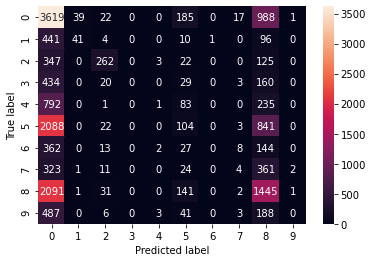

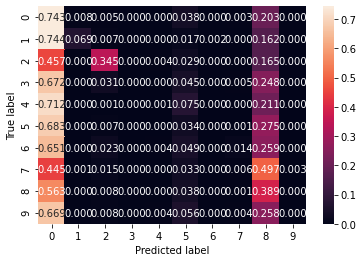

              precision    recall  f1-score   support

           0      0.329     0.743     0.457      4871
           1      0.500     0.069     0.121       593
           2      0.668     0.345     0.455       759
           3      0.000     0.000     0.000       646
           4      0.111     0.001     0.002      1112
           5      0.156     0.034     0.056      3058
           6      0.000     0.000     0.000       556
           7      0.100     0.006     0.010       726
           8      0.315     0.389     0.348      3712
           9      0.000     0.000     0.000       728

    accuracy                          0.327     16761
   macro avg      0.218     0.159     0.145     16761
weighted avg      0.254     0.327     0.246     16761



C:\Users\Gerardo\.conda\envs\capstone2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [229]:
confusion(ytest, ypred)

## t-SNE

In [69]:
X, y = label_encoder(df_ML,'classification')
print(y)
X1 = X.drop(['structureId','structureMolecularWeight','phValue','sequence'], axis=1)
X1

[0 0 0 ... 6 8 5]


MoreauBrotoAuto_ResidueASA27  MoreauBrotoAuto_ResidueASA26  \
0                            -0.073                         0.937   
1                             0.183                         1.145   
2                             0.183                         1.145   
3                            -0.063                         0.901   
4                            -0.063                         0.901   
...                             ...                           ...   
55862                        -0.021                         0.891   
55863                        -0.062                         0.915   
55864                        -0.027                         0.880   
55865                         0.043                         1.069   
55866                         0.059                         0.974   

       MoreauBrotoAuto_ResidueASA25  MoreauBrotoAuto_ResidueASA24  \
0                             0.021                         0.056   
1                            -0.013                         0.171   
2                            -0.013                         0.171   
3                            -0.073                        -0.007   
4                            -0.073                        -0.007   
...                             ...                           ...   
55862                        -0.003                         0.085   
55863                        -0.074                         0.001   
55864                        -0.084                        -0.018   
55865                        -0.036                         0.029   
55866                         0.075                         0.019   

       MoreauBrotoAuto_ResidueASA23  MoreauBrotoAuto_ResidueASA22  \
0                             0.052                        -0.013   
1                             0.171                         0.060   
2                             0.171                         0.060   
3                            -0.001                         0.042   
4                            -0.001                         0.042   
...                             ...                           ...   
55862                         0.089                        -0.017   
55863                         0.008                         0.044   
55864                        -0.002                        -0.131   
55865                         0.034                         0.075   
55866                         0.020                        -0.025   

       MoreauBrotoAuto_ResidueASA21  MoreauBrotoAuto_ResidueASA20  \
0                            -0.009                         0.047   
1                             0.055                         0.176   
2                             0.055                         0.176   
3                             0.042                         0.004   
4                             0.042                         0.004   
...                             ...                           ...   
55862                        -0.018                         0.088   
55863                         0.043                         0.012   
55864                        -0.124                         0.006   
55865                         0.075                         0.040   
55866                        -0.023                         0.018   

       MoreauBrotoAuto_ResidueASA29  MoreauBrotoAuto_ResidueASA28  ...  \
0                             0.048                         0.049  ...   
1                             0.162                         0.168  ...   
2                             0.162                         0.168  ...   
3                             0.009                         0.005  ...   
4                             0.009                         0.005  ...   
...                             ...                           ...  ...   
55862                         0.090                         0.091  ...   
55863                         0.017                         0.013  ...   
55864                    

In [145]:
# Run PCA with 81 components

pca = PCA(n_components=81)
df_ML_50 = pd.DataFrame(
    pca.fit_transform(X1),
    columns = ['PC'+str(i+1) for i in range(pca.n_components)], 
    index   = X1.index)
# df_ML_50 = pca.fit_transform(digits.values)

print("Cumulative variance explained by first {} Principal Components: {}".format(pca.n_components, np.sum(pca.explained_variance_ratio_)))

Cumulative variance explained by first 81 Principal Components: 0.8141752706548101


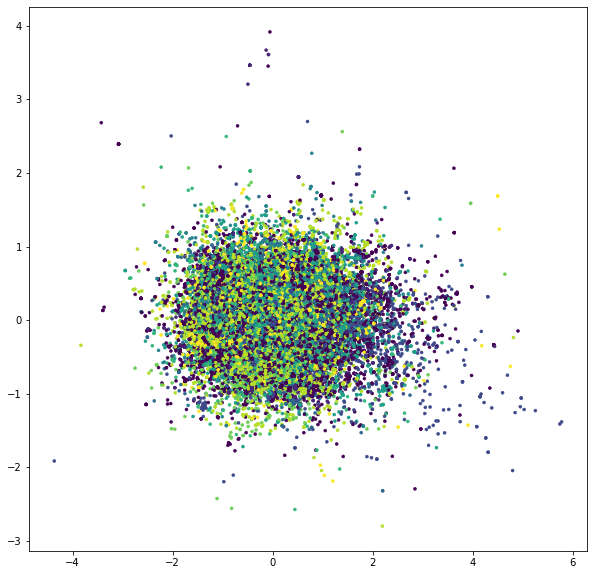

In [146]:
# plot normal and labelled pca (first 2 components)
plot_PCA(df_ML_50, y)

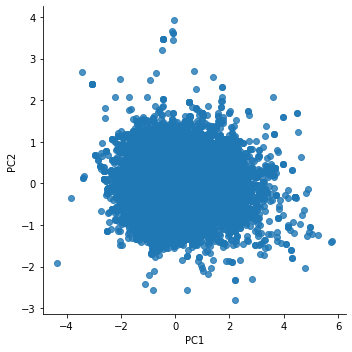

In [135]:
sns.lmplot(x='PC1', y='PC2', data=df_ML_50.iloc[:,:2], fit_reg=False)

In [129]:
tsne.set_params()

params = {
#         'angle': 0.5,
#         'early_exaggeration': 12.0,
#         'init': 'random',
        'learning_rate': [1000],
#         'method': 'barnes_hut',
        'metric': ['euclidean','minkowski'],
#         'min_grad_norm': [1e-07],
        'n_components': [2],
#         'n_iter': 1000,
#         'n_iter_without_progress': 300,
#         'n_jobs': None,
        'perplexity': [80],
#         'random_state': None,
        'verbose': [2]
}
paramss = list(ParameterGrid(params))
len(paramss)
# paramss[0]

2

{'learning_rate': 1000, 'metric': 'euclidean', 'n_components': 2, 'perplexity': 80, 'verbose': 2}
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.297s...
[t-SNE] Computed neighbors for 10000 samples in 26.816s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 1.483s
[t-S

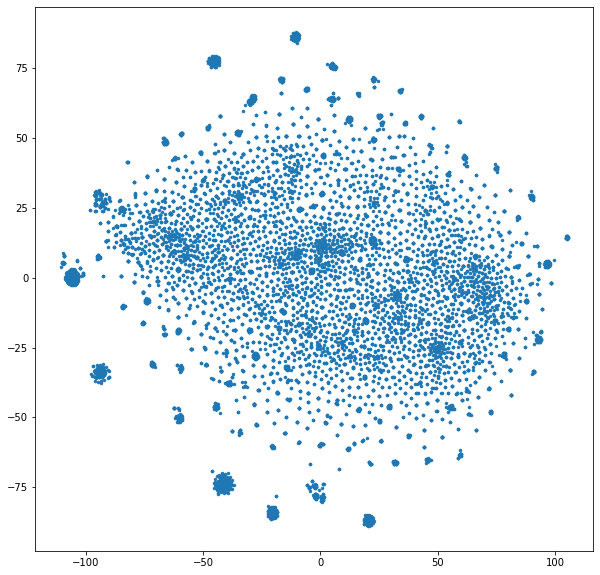

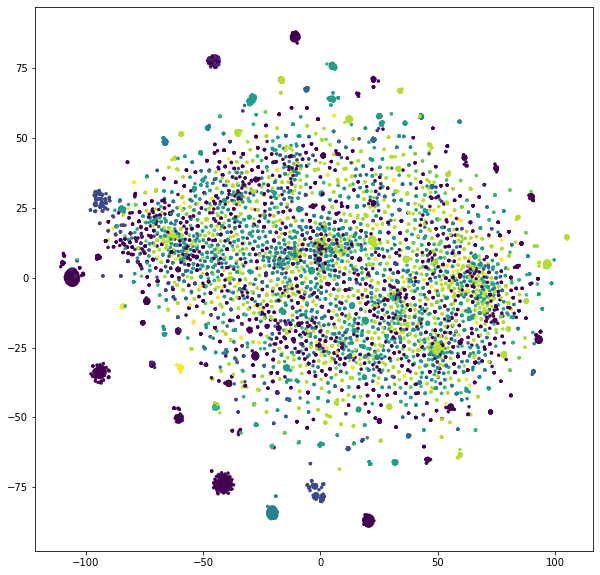

{'learning_rate': 1000, 'metric': 'minkowski', 'n_components': 2, 'perplexity': 80, 'verbose': 2}
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.538s...
[t-SNE] Computed neighbors for 10000 samples in 39.354s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 2.726s
[t-S

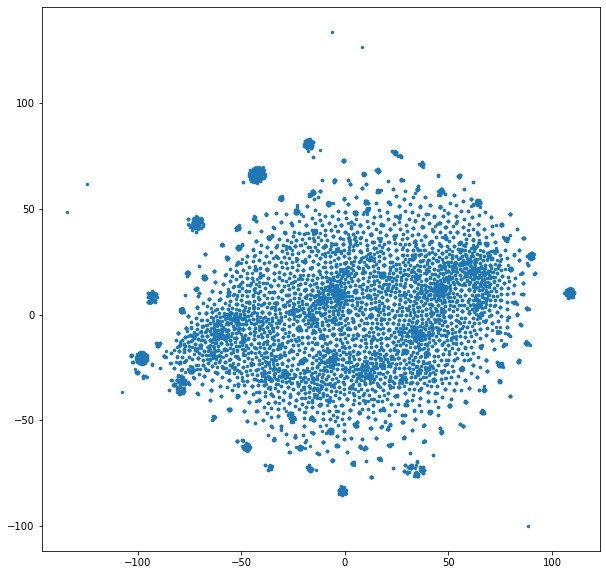

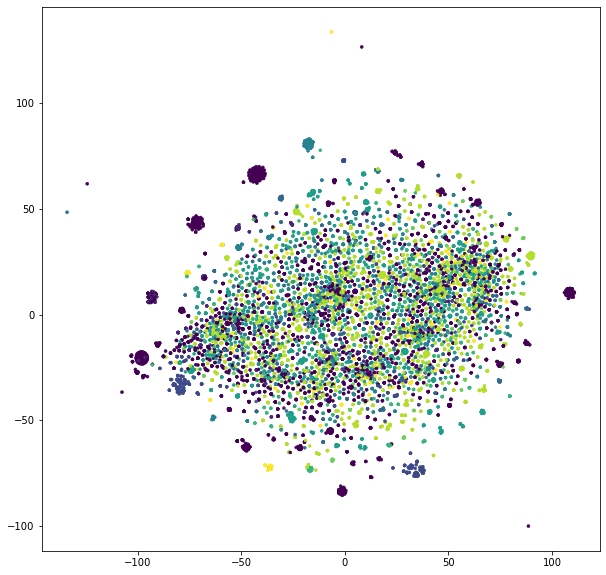

In [130]:
iterate_tsnes(df_ML_50, paramss, 10000)

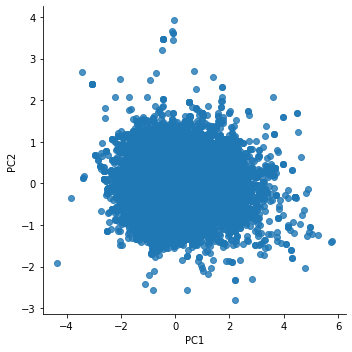

In [135]:
sns.lmplot(x='PC1', y='PC2', data=df_ML_50.iloc[:,:2], fit_reg=False)

In [154]:
tsne.set_params()

params = {
#         'angle': 0.5,
#         'early_exaggeration': 12.0,
#         'init': 'random',
        'learning_rate': [1000],
#         'method': 'barnes_hut',
        'metric': ['euclidean','minkowski'],
#         'min_grad_norm': [1e-07],
        'n_components': [2],
#         'n_iter': 1000,
#         'n_iter_without_progress': 300,
#         'n_jobs': None,
        'perplexity': [80],
#         'random_state': None,
        'verbose': [2]
}
paramss = list(ParameterGrid(params))
len(paramss)
# paramss[0]

2

In [155]:
iterate_tsnes(df_ML_50, paramss, 10000)

{'learning_rate': 1000, 'metric': 'euclidean', 'n_components': 2, 'perplexity': 80, 'verbose': 2}
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.287s...
[t-SNE] Computed neighbors for 10000 samples in 25.285s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 1.887s
[t-S

KeyboardInterrupt: 

{'learning_rate': 1000, 'metric': 'euclidean', 'n_components': 2, 'perplexity': 80, 'verbose': 2}
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.255s...
[t-SNE] Computed neighbors for 10000 samples in 23.720s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 1.468s
[t-S

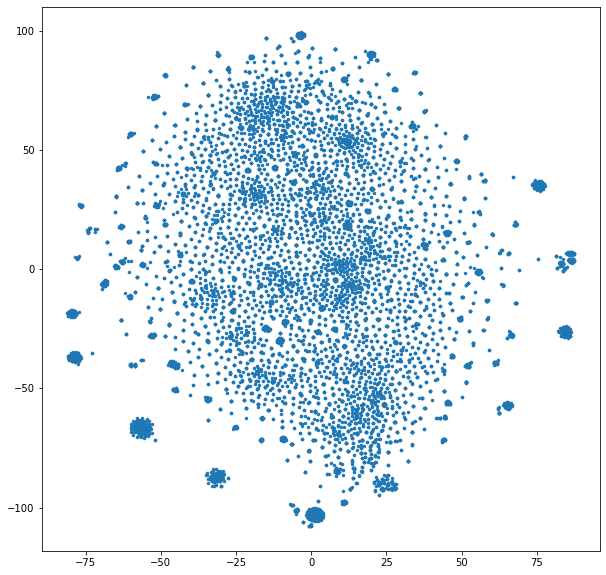

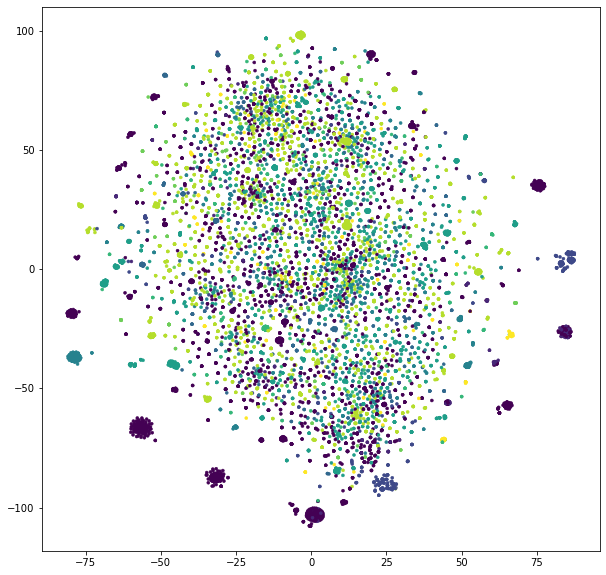

{'learning_rate': 1000, 'metric': 'minkowski', 'n_components': 2, 'perplexity': 80, 'verbose': 2}
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.266s...
[t-SNE] Computed neighbors for 10000 samples in 23.177s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 1.506s
[t-S

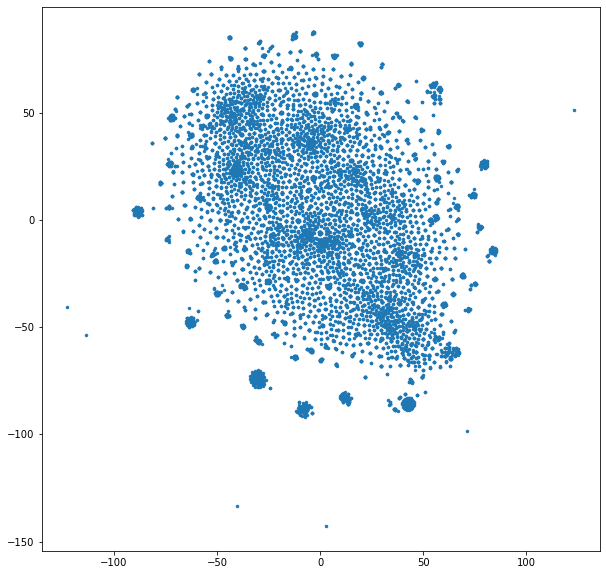

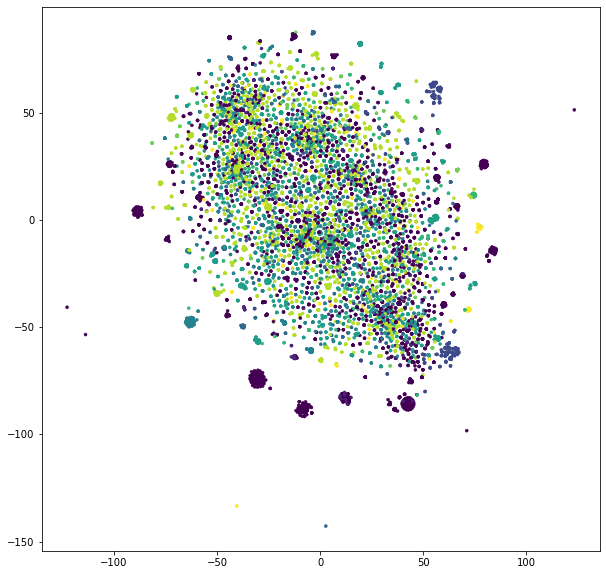

In [121]:
iterate_tsnes(df_ML_50, paramss, 10000)

In [74]:
# Run t-SNE
from sklearn.manifold import TSNE
n_samples = 1000
df_ML_50_1 = df_ML_50.iloc[:n_samples,:]
tsne = TSNE(
    n_components=2, 
    perplexity=40, 
    verbose=2)

digits_tsne = tsne.fit_transform(df_ML_50_1)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.017s...
[t-SNE] Computed neighbors for 1000 samples in 0.232s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.655996
[t-SNE] Computed conditional probabilities in 0.059s
[t-SNE] Iteration 50: error = 70.1621933, gradient norm = 0.2953522 (50 iterations in 0.654s)
[t-SNE] Iteration 100: error = 68.7304230, gradient norm = 0.2907227 (50 iterations in 0.596s)
[t-SNE] Iteration 150: error = 69.2765198, gradient norm = 0.2852011 (50 iterations in 0.571s)
[t-SNE] Iteration 200: error = 70.1068268, gradient norm = 0.2662576 (50 iterations in 0.588s)
[t-SNE] Iteration 250: error = 71.0175171, gradient norm = 0.2615774 (50 iterations in 0.588s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.017517
[t-SNE] Iteration 300: error = 0.9730204, gradient norm = 0.0025089 (50 iterations in 0.512s)
[t-SNE] Iteration 350: error = 0.8899063, gradient norm = 0.0004

In [ ]:
def plot_tsne(labels):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        labels.TSNE1.values, 
        labels.TSNE2.values, 
        marker='.', 
        linewidths=0.5, 
    )
    plt.show()

labels = pd.DataFrame()
labels["TSNE1"] = digits_tsne[:,0]
labels["TSNE2"] = digits_tsne[:,1]
labels['ground_truth'] = y[:n_samples]
plot_tsne(labels)

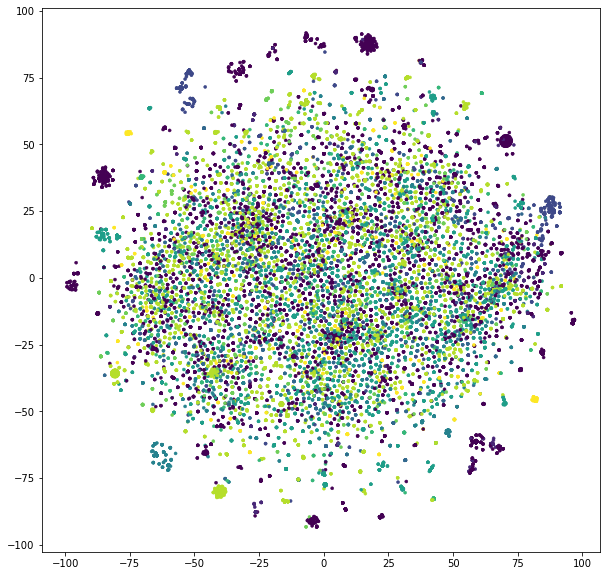

In [361]:
# Plot the results with points coloured by digit
def plot_coloured_tsne(labels):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        labels.TSNE1.values, 
        labels.TSNE2.values, 
        marker='.', 
        linewidths=0.5,
        c=labels.ground_truth,
    )
    plt.show()

plot_coloured_tsne(labels) #[labels.ground_truth==0])

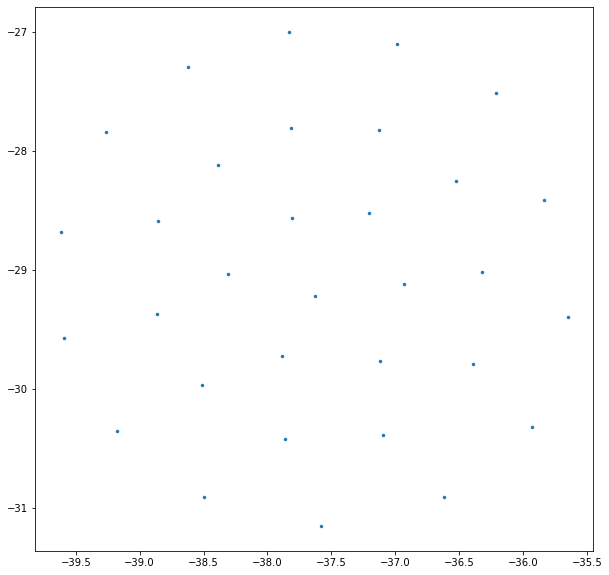

In [347]:
-41, -35   -25, -35
ciao = pd.DataFrame(digits_tsne)
sorte = ciao[(ciao[0] >=-41) & (ciao[0] <=-35) & (ciao[1] >=-35) & (ciao[1] <=-25)]
fig = plt.figure(figsize=(10, 10))
plt.scatter(
        sorte[0].values, 
        sorte[1].values,
        marker='.', 
        linewidths=0.5)

plt.show()

### To plot the Moran descriptors only

it seems the Moran MoreauBroto and Geary descriptors are highly correlated between them

In [ ]:
zip_file = "11797_16251_bundle_archive.zip"
file_list = ['pdb_data_seq.csv','pdb_data_no_dups.csv']

df_masked = clean3(zip_file, file_list)

df_descriptors = pd.read_csv(r"C:\Users\Gerardo\ADB\Capstone\PyBioMed-1.0\descr_kaggledataset_autocorrelation.csv")

df_ML = pd.merge(df_masked, df_descriptors, how='inner')

X, y = label_encoder(df_ML,'classification')
print(y)
X1 = X.drop(['structureId','structureMolecularWeight','phValue','sequence'], axis=1)
X1

In [123]:
columns_to_investigate = [item for item in X1.columns if "Moran" in item]

In [124]:
pca = PCA(n_components= 80)  #len(columns_to_investigate))
df_ML_50_moran = pd.DataFrame(
    pca.fit_transform(X1[columns_to_investigate]),
    columns = ['PC'+str(i+1) for i in range(pca.n_components)], 
    index   = X1.index) #X1.iloc[:,:11].index)
# df_ML_50 = pca.fit_transform(digits.values)

print("Cumulative variance explained by first 80 Principal Components: {}".format(np.sum(pca.explained_variance_ratio_)))

Cumulative variance explained by first 80 Principal Components: 0.8977491977727791


In [125]:
loadings = pd.DataFrame(pca.components_, 
                        columns = columns_to_investigate,   #X1.columns[:11],
                        index = df_ML_50_moran.columns)
plt.figure(figsize=(20, 16))
sns.heatmap(
        loadings.transpose(), 
        linewidths=0.5, 
        cmap="RdBu", 
        vmin=-1, vmax=1, annot=True )

Error in callback <function flush_figures at 0x0000025D044D8EA0> (for post_execute):


KeyboardInterrupt: 

    Explained Var  Cumulative Var
0       18.046563       18.046563
1        6.036268       24.082831
2        4.975701       29.058532
3        3.801975       32.860507
4        3.101029       35.961536
..            ...             ...
75       0.295400       88.632778
76       0.292073       88.924851
77       0.287126       89.211977
78       0.284291       89.496269
79       0.278651       89.774920

[80 rows x 2 columns]


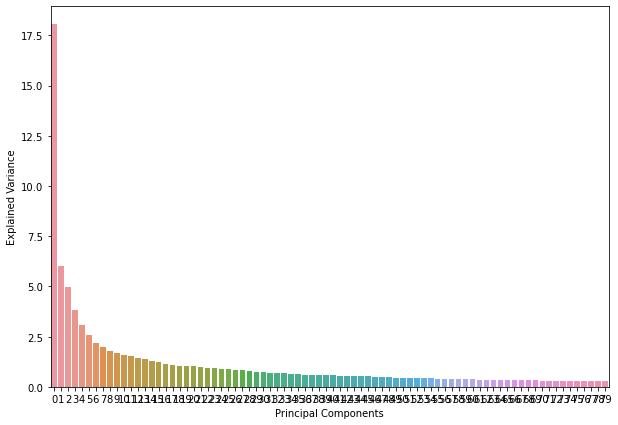

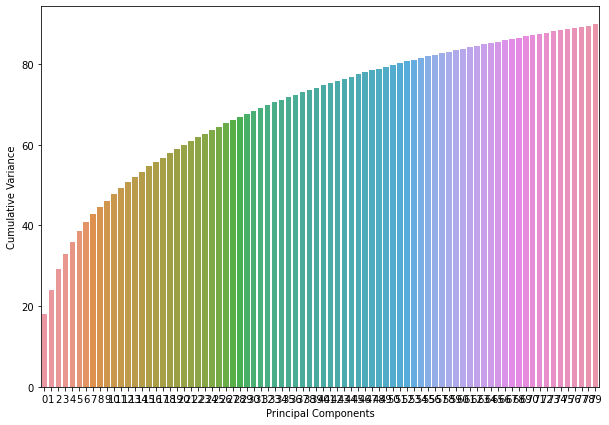

In [126]:
variance_data(pca)

{'learning_rate': 1000, 'metric': 'euclidean', 'n_components': 2, 'perplexity': 80, 'verbose': 2}
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.642s...
[t-SNE] Computed neighbors for 20000 samples in 95.224s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed c

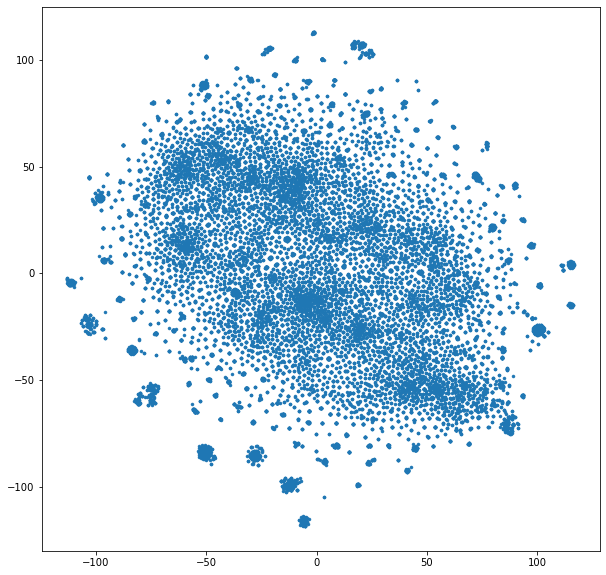

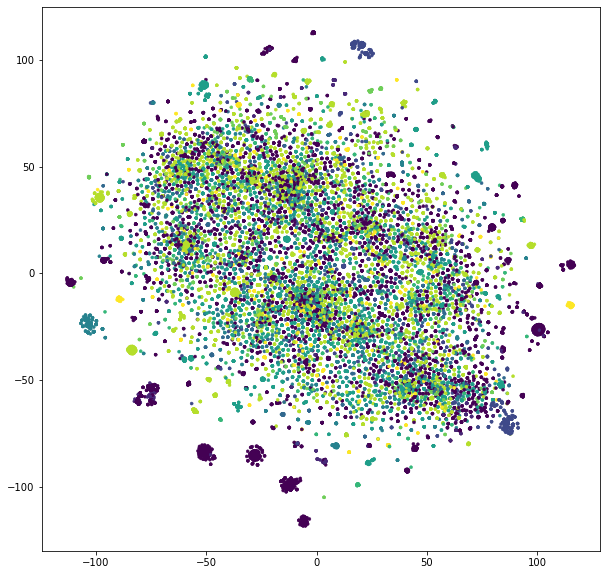

{'learning_rate': 1000, 'metric': 'minkowski', 'n_components': 2, 'perplexity': 80, 'verbose': 2}
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.683s...
[t-SNE] Computed neighbors for 20000 samples in 94.452s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed c

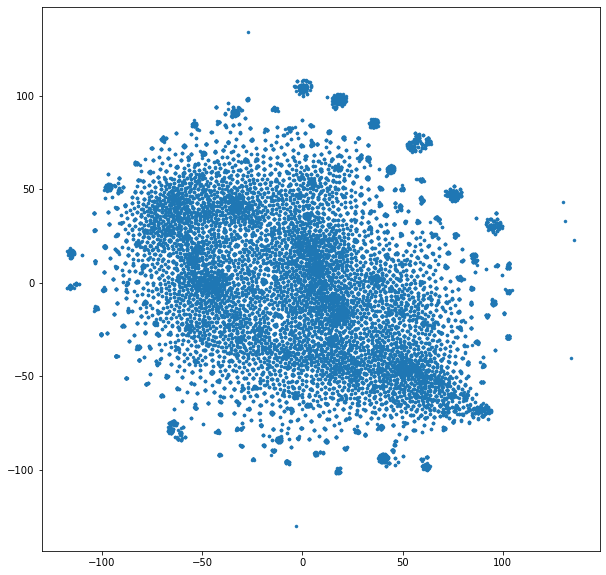

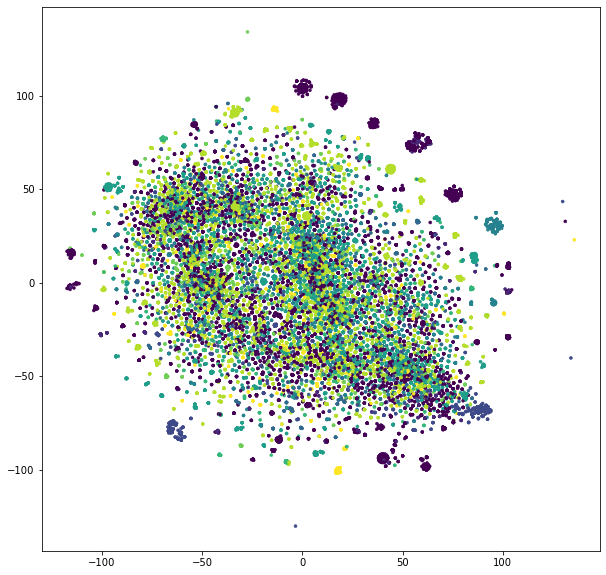

In [127]:
# Run t-SNE
from sklearn.manifold import TSNE

df_ML_50_moran_tsne = df_ML_50_moran.iloc[:20000,:]

# digits_tsne = TSNE(
#     n_components=2, 
#     perplexity=40, 
#     verbose=2).fit_transform(df_ML_50_moran_tsne)

params = {
#         'angle': 0.5,
#         'early_exaggeration': 12.0,
#         'init': 'random',
        'learning_rate': [1000],
#         'method': 'barnes_hut',
        'metric': ['euclidean','minkowski'],
#         'min_grad_norm': [1e-07],
        'n_components': [2],
#         'n_iter': 1000,
#         'n_iter_without_progress': 300,
#         'n_jobs': None,
        'perplexity': [80],
#         'random_state': None,
        'verbose': [2]
}
paramss = list(ParameterGrid(params))
iterate_tsnes(df_ML_50_moran, paramss, 20000)

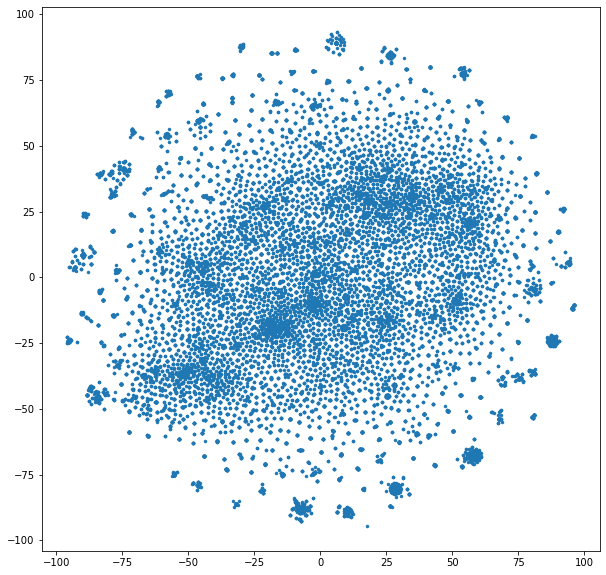

In [436]:
def plot_tsne(labels):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        labels.TSNE1.values, 
        labels.TSNE2.values, 
        marker='.', 
        linewidths=0.5, 
    )
    plt.show()

labels = pd.DataFrame()
labels["TSNE1"] = digits_tsne[:,0]
labels["TSNE2"] = digits_tsne[:,1]
labels['ground_truth'] = y[:20000]
plot_tsne(labels)

Plot coloured with the labels

In [ ]:
# Plot the results with points coloured by digit
def plot_coloured_tsne(labels):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        labels.TSNE1.values, 
        labels.TSNE2.values, 
        marker='.', 
        linewidths=0.5,
        c=labels.ground_truth,
    )
    plt.show()

plot_coloured_tsne(labels) #[labels.ground_truth==])

## Variance thresholding

In [4]:
zip_file = "11797_16251_bundle_archive.zip"
file_list = ['pdb_data_seq.csv','pdb_data_no_dups.csv']

df_masked = clean3(zip_file, file_list)

df_descriptors = pd.read_csv(r"C:\Users\Gerardo\ADB\Capstone\PyBioMed-1.0\descr_kaggledataset_autocorrelation.csv")

df_ML = pd.merge(df_masked, df_descriptors, how='inner')

X, y = label_encoder(df_ML,'classification')
print(y)
X1 = X.drop(['structureId','structureMolecularWeight','phValue','sequence'], axis=1)
X1

[0 0 0 ... 6 8 5]


MoreauBrotoAuto_ResidueASA27  MoreauBrotoAuto_ResidueASA26  \
0                            -0.073                         0.937   
1                             0.183                         1.145   
2                             0.183                         1.145   
3                            -0.063                         0.901   
4                            -0.063                         0.901   
...                             ...                           ...   
55862                        -0.021                         0.891   
55863                        -0.062                         0.915   
55864                        -0.027                         0.880   
55865                         0.043                         1.069   
55866                         0.059                         0.974   

       MoreauBrotoAuto_ResidueASA25  MoreauBrotoAuto_ResidueASA24  \
0                             0.021                         0.056   
1                            -0.013                         0.171   
2                            -0.013                         0.171   
3                            -0.073                        -0.007   
4                            -0.073                        -0.007   
...                             ...                           ...   
55862                        -0.003                         0.085   
55863                        -0.074                         0.001   
55864                        -0.084                        -0.018   
55865                        -0.036                         0.029   
55866                         0.075                         0.019   

       MoreauBrotoAuto_ResidueASA23  MoreauBrotoAuto_ResidueASA22  \
0                             0.052                        -0.013   
1                             0.171                         0.060   
2                             0.171                         0.060   
3                            -0.001                         0.042   
4                            -0.001                         0.042   
...                             ...                           ...   
55862                         0.089                        -0.017   
55863                         0.008                         0.044   
55864                        -0.002                        -0.131   
55865                         0.034                         0.075   
55866                         0.020                        -0.025   

       MoreauBrotoAuto_ResidueASA21  MoreauBrotoAuto_ResidueASA20  \
0                            -0.009                         0.047   
1                             0.055                         0.176   
2                             0.055                         0.176   
3                             0.042                         0.004   
4                             0.042                         0.004   
...                             ...                           ...   
55862                        -0.018                         0.088   
55863                         0.043                         0.012   
55864                        -0.124                         0.006   
55865                         0.075                         0.040   
55866                        -0.023                         0.018   

       MoreauBrotoAuto_ResidueASA29  MoreauBrotoAuto_ResidueASA28  ...  \
0                             0.048                         0.049  ...   
1                             0.162                         0.168  ...   
2                             0.162                         0.168  ...   
3                             0.009                         0.005  ...   
4                             0.009                         0.005  ...   
...                             ...                           ...  ...   
55862                         0.090                         0.091  ...   
55863                         0.017                         0.013  ...   
55864                    

In [34]:
sel = VarianceThreshold(threshold=0.01)
# columns_to_investigate = [item for item in X1.columns if "Moran" in item]
sel.fit(X1)
sel.get_support()
# X1[columns_to_investigate].corr()

# compute_pca(X1[columns_to_investigate], n_comp=30).corr()

# X1[columns_to_investigate]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [37]:
almostconstant_columns = [column for column in X1.columns
                    if column not in X1.columns[sel.get_support()]]

In [39]:
almostconstant_columns

['MoreauBrotoAuto_ResidueASA27',
 'MoreauBrotoAuto_ResidueASA26',
 'MoreauBrotoAuto_ResidueASA25',
 'MoreauBrotoAuto_ResidueASA24',
 'MoreauBrotoAuto_ResidueASA23',
 'MoreauBrotoAuto_ResidueASA22',
 'MoreauBrotoAuto_ResidueASA21',
 'MoreauBrotoAuto_ResidueASA20',
 'MoreauBrotoAuto_ResidueASA29',
 'MoreauBrotoAuto_ResidueASA28',
 'MoreauBrotoAuto_ResidueVol30',
 'MoreauBrotoAuto_AvFlexibility19',
 'MoreauBrotoAuto_AvFlexibility18',
 'MoreauBrotoAuto_Mutability29',
 'MoreauBrotoAuto_Mutability28',
 'MoreauBrotoAuto_AvFlexibility15',
 'MoreauBrotoAuto_AvFlexibility14',
 'MoreauBrotoAuto_AvFlexibility17',
 'MoreauBrotoAuto_AvFlexibility16',
 'MoreauBrotoAuto_AvFlexibility11',
 'MoreauBrotoAuto_AvFlexibility10',
 'MoreauBrotoAuto_AvFlexibility13',
 'MoreauBrotoAuto_AvFlexibility12',
 'MoreauBrotoAuto_Polarizability13',
 'MoreauBrotoAuto_Polarizability12',
 'MoreauBrotoAuto_Polarizability11',
 'MoreauBrotoAuto_Polarizability10',
 'MoreauBrotoAuto_Polarizability17',
 'MoreauBrotoAuto_Polariza

In [41]:
sse = sel.transform(X1)

In [55]:
todo = X1[list(set(X1.columns) - set(almostconstant_columns))]

In [44]:
sel.

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [59]:
# Run t-SNE
from sklearn.manifold import TSNE

# df_ML_50_moran_tsne = df_ML_50_moran.iloc[:20000,:]

digits_tsne = TSNE(
    n_components=2, 
    perplexity=40, 
    verbose=2).fit_transform(todo.iloc[:5000,:])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.056s...
[t-SNE] Computed neighbors for 5000 samples in 0.349s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.489s
[t-SNE] Iteration 50: error = 77.0334015, gradient norm = 0.0430389 (50 iterations in 3.742s)
[t-SNE] Iteration 100: error = 64.0155563, gradient norm = 0.0115364 (50 iterations in 2.354s)
[t-SNE] Iteration 150: error = 61.5179138, gradient norm = 0.0049522 (50 iterations in 2.219s)
[t-SNE] Iteration 200: error = 60.4260483, gradient norm = 0.0043193 (50 iterations in 2.247s)
[t-SNE] Iteration 250: error = 59.7977371, gradient norm = 0.002990

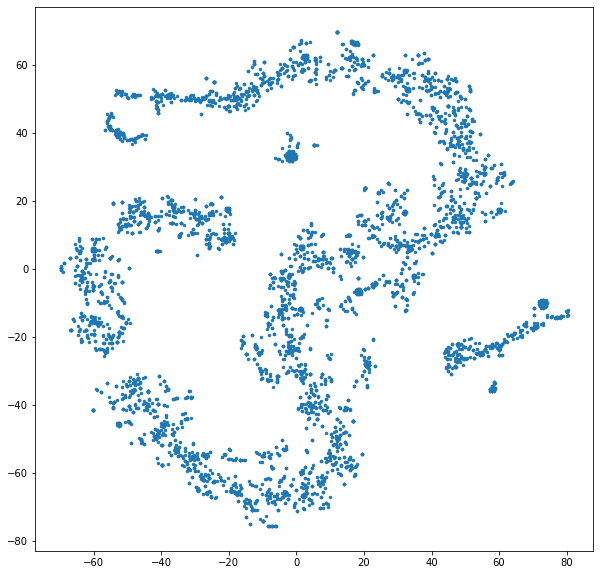

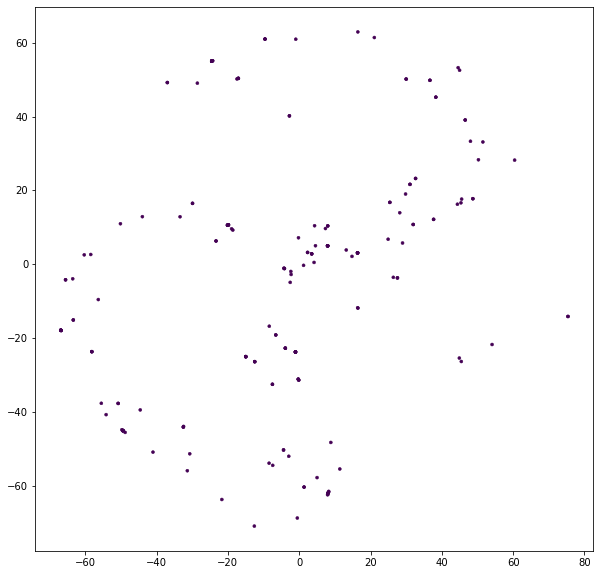

In [68]:
def plot_tsne(labels):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        labels.TSNE1.values, 
        labels.TSNE2.values, 
        marker='.', 
        linewidths=0.5, 
    )
    plt.show()

labels = pd.DataFrame()
labels["TSNE1"] = digits_tsne[:,0]
labels["TSNE2"] = digits_tsne[:,1]
labels['ground_truth'] = y[:5000]
plot_tsne(labels)

# Plot the results with points coloured by digit
def plot_coloured_tsne(labels):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        labels.TSNE1.values, 
        labels.TSNE2.values, 
        marker='.', 
        linewidths=0.5,
        c=labels.ground_truth,
    )
    plt.show()

plot_coloured_tsne(labels[labels.ground_truth==3])

In [ ]:
digits_tsne.

## FInal All descriptors

In [3]:
zip_file = "11797_16251_bundle_archive.zip"
file_list = ['pdb_data_seq.csv','pdb_data_no_dups.csv']

df_masked = clean3(zip_file, file_list)

df_descriptors = pd.read_csv(r"C:\Users\Gerardo\ADB\Capstone\PyBioMed-1.0\descr_kaggledataset_autocorrelation.csv")

df_ML = pd.merge(df_masked, df_descriptors, how='inner')

### New PCA

In [4]:
X, y, classes = label_encoder(df_ML,'classification')
print(y)
X1 = X.drop(['structureId','structureMolecularWeight','phValue','sequence'], axis=1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y, test_size=0.2, random_state=123, stratify=y)

[0 0 0 ... 6 8 5]


In [5]:
def scale_and_pca(Xtrain, Xtest, n_comp):
    
    ss = StandardScaler()
    Xtrain = pd.DataFrame(ss.fit_transform(Xtrain),
                          columns=Xtrain.columns,
                          index=Xtrain.index)
    Xtest = pd.DataFrame(ss.transform(Xtest),
                          columns=Xtest.columns,
                          index=Xtest.index)
    pca = PCA(n_components=n_comp)
    pca_train = pd.DataFrame(pca.fit_transform(Xtrain),
                          columns = ['PC'+str(i+1) for i in range(n_comp)],
                          index=Xtrain.index)
    pca_test = pd.DataFrame(pca.transform(Xtest),
                          columns = ['PC'+str(i+1) for i in range(n_comp)],
                          index=Xtest.index)
    return pca_train, pca_test, pca

# scale_and_pca(Xtrain, Xtest, 3)

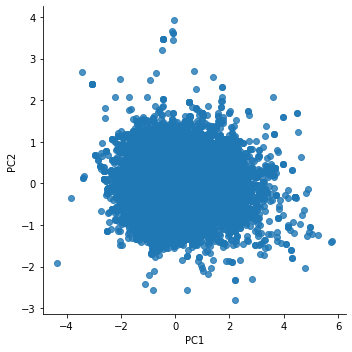

In [135]:
sns.lmplot(x='PC1', y='PC2', data=df_ML_50.iloc[:,:2], fit_reg=False)

In [33]:
def compute_pca(Xtrain, Xtest, n_comp, y=None, return_data=False):
    pca_train, pca_test, pca = scale_and_pca(Xtrain, Xtest, n_comp)
    print("Cumulative variance explained by first {} Principal Components: {}".format(pca.n_components, np.sum(pca.explained_variance_ratio_)))    # df_ML_50 = pca.fit_transform(digits.values)
    pca_df = pd.concat([pca_train,pca_test])
    plot_PCA(pca_df, np.concatenate([ytrain,ytest]))
    variance_data(pca)
    loadings = pd.DataFrame(pca.components_, 
                        columns = Xtrain.columns,
                        index = pca_train.columns)

    print(loadings.iloc[0:1,:].transpose().sort_values('PC1',ascending=False).head(5))
    print(loadings.iloc[1:2,:].transpose().sort_values('PC2',ascending=False).head(5))
    print(loadings.iloc[2:3,:].transpose().sort_values('PC3',ascending=False).head(5))
    
    if return_data==True: return pca_train, pca_test, pca_df
    


Cumulative variance explained by first 81 Principal Components: 0.8017468925933771


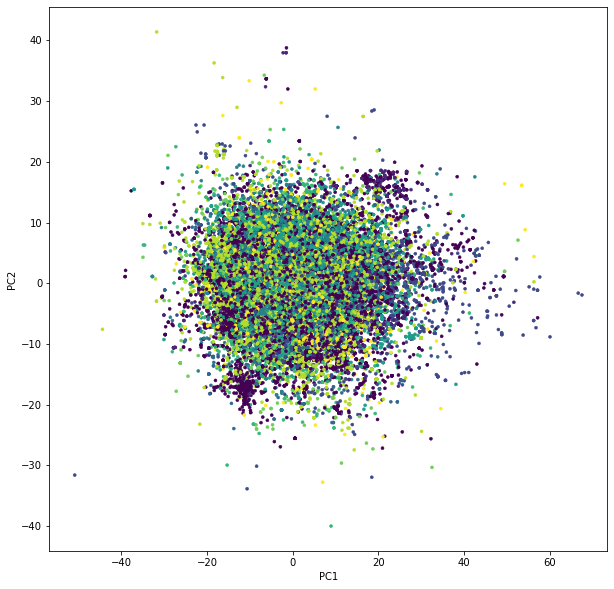

   Explained Var  Cumulative Var
0      14.685377       14.685377
1       5.882891       20.568268
2       4.343530       24.911798
3       3.681844       28.593642
4       3.128622       31.722264
5       3.003255       34.725519
6       2.445935       37.171455
7       1.752706       38.924161
8       1.435531       40.359692
9       1.337154       41.696846
                             PC1
GearyAuto_Steric7       0.092990
GearyAuto_Steric2       0.092921
GearyAuto_Steric8       0.092920
GearyAuto_Steric6       0.092803
GearyAuto_ResidueASA30  0.092686
                                   PC2
GearyAuto_ResidueVol13        0.116454
MoreauBrotoAuto_Mutability10  0.108937
GearyAuto_Mutability7         0.044420
MoranAuto_ResidueASA19        0.044318
GearyAuto_ResidueASA9         0.044297
                                   PC3
MoreauBrotoAuto_ResidueASA18  0.139425
MoreauBrotoAuto_Steric28      0.138851
MoranAuto_Hydrophobicity16    0.138790
MoranAuto_Steric25            0.138585
MoranAuto_

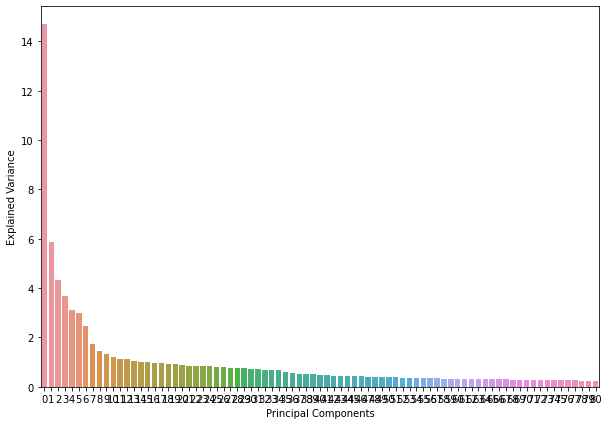

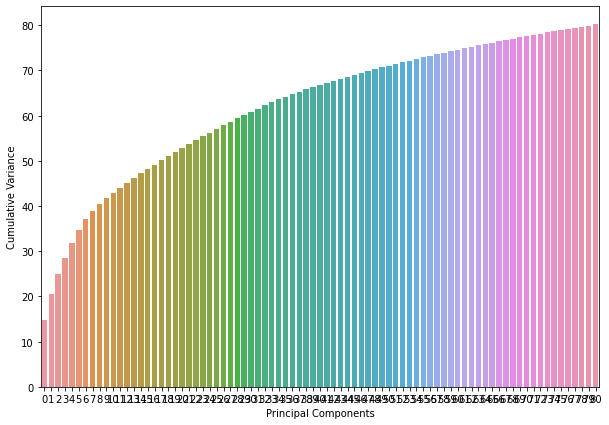

In [34]:
# Run PCA with 50 components
pca_train, pca_test, pca_df = compute_pca(Xtrain, Xtest, 81, y, return_data=True)


To plot first pca loadings

In [35]:
loadings = pd.DataFrame(pca.components_, 
                        columns = X1.columns,
                        index = pca_train.columns)

In [36]:
loadings.iloc[0:1,:].transpose().sort_values('PC1',ascending=False).head(5)

PC1
GearyAuto_Steric7       0.092990
GearyAuto_Steric2       0.092921
GearyAuto_Steric8       0.092920
GearyAuto_Steric6       0.092803
GearyAuto_ResidueASA30  0.092686

In [31]:
loadings.iloc[1:2,:].transpose().sort_values('PC2',ascending=False).head(5)

PC2
GearyAuto_ResidueVol13        0.116454
MoreauBrotoAuto_Mutability10  0.108937
GearyAuto_Mutability7         0.044420
MoranAuto_ResidueASA19        0.044318
GearyAuto_ResidueASA9         0.044297

In [30]:
loadings.iloc[2:3,:].transpose().sort_values('PC3',ascending=False).head(5)

PC3
MoreauBrotoAuto_ResidueASA18  0.139425
MoreauBrotoAuto_Steric28      0.138851
MoranAuto_Hydrophobicity16    0.138790
MoranAuto_Steric25            0.138585
MoranAuto_Steric22            0.138339

#### t-SNE

{'learning_rate': 1000, 'metric': 'euclidean', 'n_components': 2, 'perplexity': 80, 'verbose': 0}


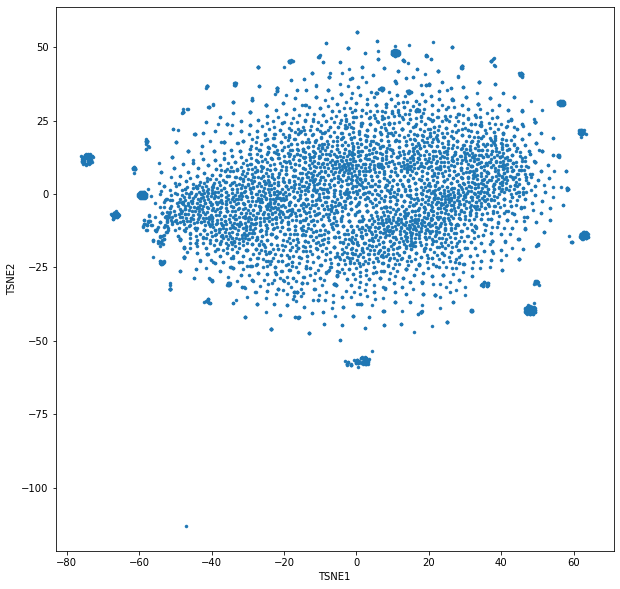

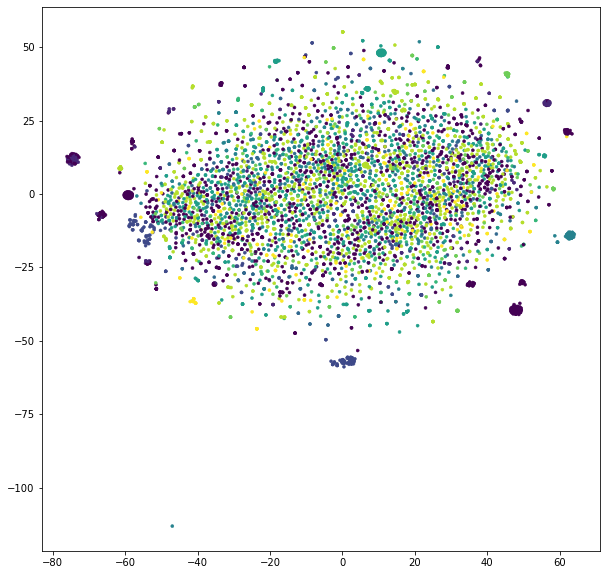

{'learning_rate': 1000, 'metric': 'minkowski', 'n_components': 2, 'perplexity': 80, 'verbose': 0}


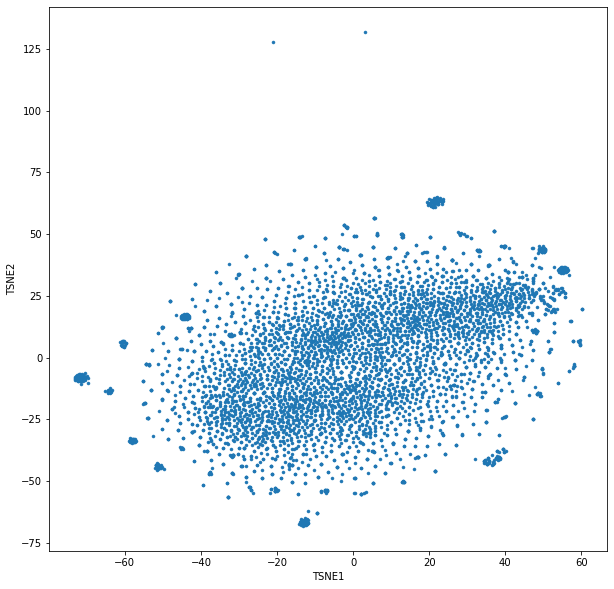

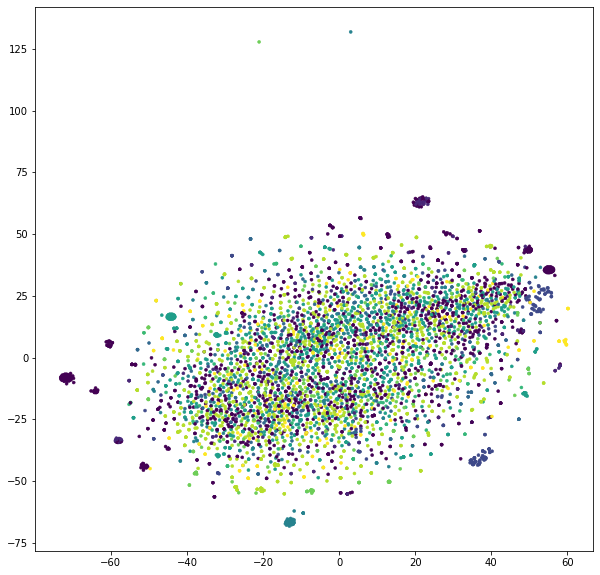

In [12]:
# tsne.set_params()

params = {
        'learning_rate': [1000],
        'metric': ['euclidean'],
        'n_components': [2],
        'perplexity': [80],
}
paramss = list(ParameterGrid(params))

iterate_tsnes(pca_df, paramss, 5000, np.concatenate([ytrain,ytest]))
# len(paramss)
# # paramss[0]

### models

In [53]:
# models
et = ExtraTreesClassifier()
ypred = et.fit(pca_train, ytrain).predict(pca_test)
print("#Mislabeled points (ET): {1} out of {0} with an accuracy score of {2}%".format(len(ytest), sum(ypred != ytest), accuracy_score(ytest, ypred)*100))

rf = RandomForestClassifier()
ypred = rf.fit(pca_train, ytrain).predict(pca_test)
print("#Mislabeled points (RF): {1} out of {0} with an accuracy score of {2}%".format(len(ytest), sum(ypred != ytest), accuracy_score(ytest, ypred)*100))

lg = LogisticRegression()
ypred = lg.fit(pca_train, ytrain).predict(pca_test)
print("#Mislabeled points (LG): {1} out of {0} with an accuracy score of {2}%".format(len(ytest), sum(ypred != ytest), accuracy_score(ytest, ypred)*100))

#Mislabeled points (ET): 1991 out of 11174 with an accuracy score of 82.18185072489709%
#Mislabeled points (RF): 2035 out of 11174 with an accuracy score of 81.78807947019867%
#Mislabeled points (LG): 6380 out of 11174 with an accuracy score of 42.903168068730984%


C:\Users\Gerardo\.conda\envs\capstone2\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Random forest

In [319]:
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV

# Utility function to report best scores
def report(results, n_top=3):

    for i in range(1, n_top + 1):

        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:

            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# use a full grid over all parameters
param_grid = {"max_depth": [3, 50],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10]}

# run grid search
grid_search = GridSearchCV(RandomForestClassifier(n_estimators=75), param_grid, n_jobs=-1)
start = time()
grid_search.fit(Xtrain, ytrain)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

report(grid_search.cv_results_)


GridSearchCV took 488.49 seconds for 18 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.781 (std: 0.003)
Parameters: {'max_depth': 50, 'max_features': 10, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.780 (std: 0.003)
Parameters: {'max_depth': 50, 'max_features': 10, 'min_samples_split': 3}

Model with rank: 3
Mean validation score: 0.779 (std: 0.003)
Parameters: {'max_depth': 50, 'max_features': 3, 'min_samples_split': 2}



#### Extra Tree classifier

In [320]:
# use a full grid over all parameters
param_grid = {"max_depth": [3, 50],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10]}

# run grid search
grid_search = GridSearchCV(ExtraTreesClassifier(n_estimators=75), param_grid, n_jobs=-1)
start = time()
grid_search.fit(Xtrain, ytrain)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

report(grid_search.cv_results_)


GridSearchCV took 151.60 seconds for 18 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.785 (std: 0.004)
Parameters: {'max_depth': 50, 'max_features': 10, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.785 (std: 0.002)
Parameters: {'max_depth': 50, 'max_features': 10, 'min_samples_split': 3}

Model with rank: 3
Mean validation score: 0.781 (std: 0.004)
Parameters: {'max_depth': 50, 'max_features': 3, 'min_samples_split': 3}



#### Further dev

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.neural_network import MLPClassifier

In [11]:
def model_select(classifier):
    cv_result = []
    cv_means = []
    # Cross validate model with Kfold stratified cross val
    kfold = StratifiedKFold(n_splits=5)
    cv_result.append(cross_val_score(classifier, pca_train, y = ytrain, scoring = "accuracy", cv = kfold, n_jobs=4, verbose=2))
    cv_means.append(np.mean(cv_result))
    return cv_means
# Fitting all the models 
model_type = [KNeighborsClassifier(),GaussianNB(),RandomForestClassifier(),
              AdaBoostClassifier(),GradientBoostingClassifier(),DecisionTreeClassifier(),ExtraTreesClassifier()]
model_score = [model_select(i) for i in model_type]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 46.9min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   20.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   

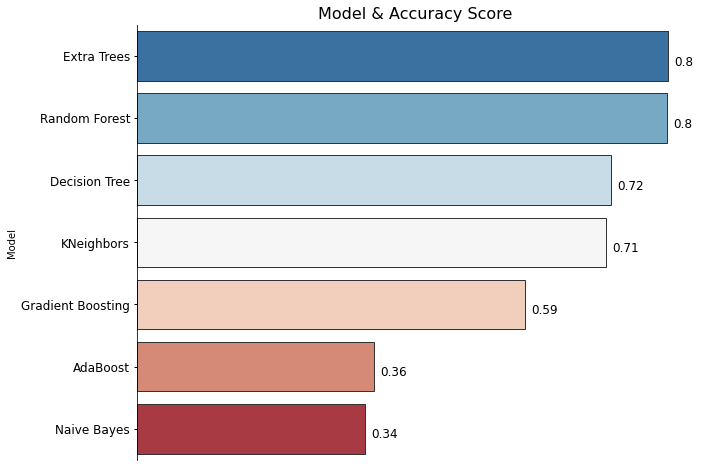

In [12]:
classifier = ['KNeighbors','Naive Bayes','Random Forest', 
             'AdaBoost','Gradient Boosting','Decision Tree','Extra Trees']
# Place result in a data Frame
ml_model = pd.DataFrame(model_score,classifier).reset_index()
ml_model.columns=['Model','acc_score']
ml_model.sort_values('acc_score',ascending = False,inplace=True)
ml_model.reset_index(drop=True,inplace = True)
f, ax = plt.subplots(figsize=(10,8))
sns.barplot('acc_score','Model',data=ml_model, ax=ax,palette='RdBu_r',edgecolor=".2")
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.01, i.get_y()+.55, \
        str(round((i.get_width()), 2)), fontsize=12, color='black') 
kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax.tick_params(**kwargs)
x_axis = ax.axes.get_xaxis().set_visible(False)
ax.set_title('Model & Accuracy Score',fontsize=16)
sns.despine(bottom=True)
plt.show()

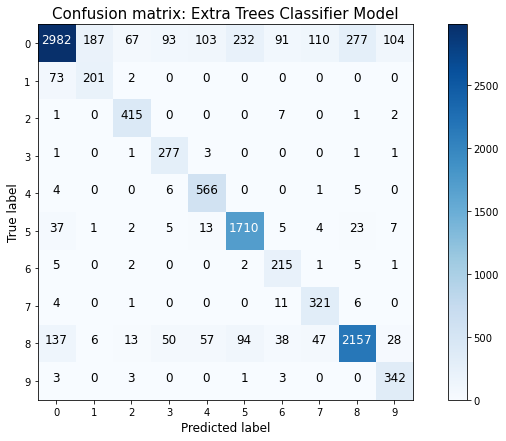

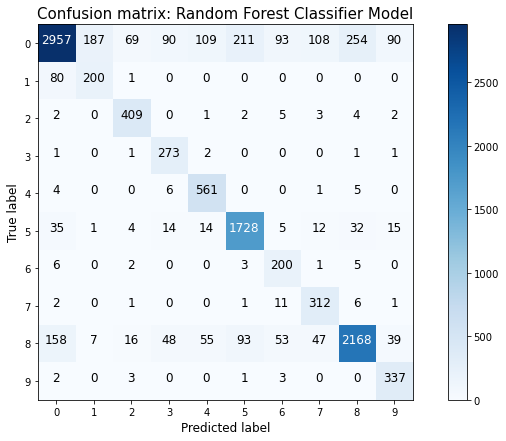

In [17]:
import itertools
# Compute confusion matrix
def single_model(model):
    clf = model
    clf.fit(pca_train,ytrain)
    ypred = clf.predict(pca_test)
    conf_mx = confusion_matrix(ypred,ytest)
    return conf_mx

#plot confusion matrix    
def plot_confusion_matrix(cm, classes,model_name):

    plt.figure(figsize=(10,6))
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix: '+ model_name, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=12)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=12,color='black')
    plt.xlabel('Predicted label',fontsize=12,color='black' )
    np.set_printoptions(precision=2)
    
    return plt.show()
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plot_confusion_matrix(single_model(ExtraTreesClassifier()), classes,'Extra Trees Classifier Model')
plot_confusion_matrix(single_model(RandomForestClassifier()), classes,'Random Forest Classifier Model')
#plot_confusion_matrix(single_model(SVC()), classes,'Support Vector Classifier Model')

In [202]:
sel = VarianceThreshold(9) #threshold=0.9999999999999999)
# columns_to_investigate = [item for item in X1.columns if "Moran" in item]
sel.fit(df_ML_50)
sel.get_support()
# X1[columns_to_investigate].corr()

# compute_pca(X1[columns_to_investigate], n_comp=30).corr()

# X1[columns_to_investigate]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [ ]:
almostconstant_columns = [column for column in df_ML_50.columns
                    if column not in df_ML_50.columns[sel.get_support()]]

In [ ]:
almostconstant_columns

In [ ]:
sse = sel.transform(X1)

In [ ]:
todo = X1[list(set(X1.columns) - set(almostconstant_columns))]

### Moran new pca

Cumulative variance explained by first 70 Principal Components: 0.8609660545146124


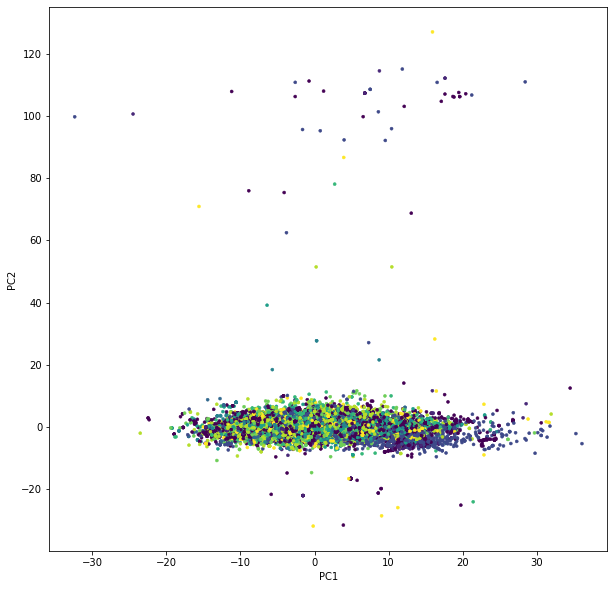

   Explained Var  Cumulative Var
0      13.798517       13.798517
1       5.519218       19.317736
2       4.747927       24.065662
3       4.350291       28.415954
4       2.835829       31.251783
5       2.507785       33.759567
6       2.233783       35.993350
7       2.072836       38.066186
8       1.802924       39.869110
9       1.670669       41.539779


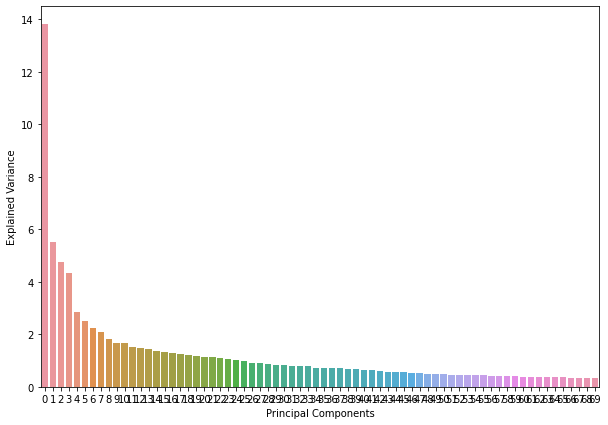

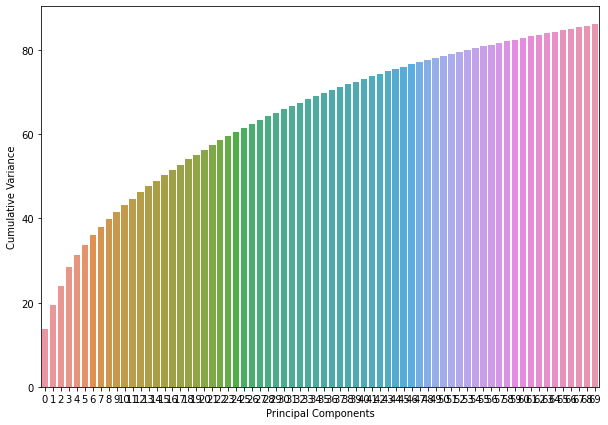

In [314]:
columns_to_investigate = [item for item in X1.columns if "Moran" in item]
pca = compute_pca(X1[columns_to_investigate], 70, y, return_data=True)
# iterate_tsnes(pca.tr, paramss, 10000, y=y)

In [315]:
pca[0].components_.shape

(70, 240)

In [316]:
loadings = pd.DataFrame(pca[0].components_, 
                        columns = columns_to_investigate,   #X1.columns[:11],
                        index = pca[1].columns)

def pca_heatmap(loadings):
    plt.figure(figsize=(10, 200))
    sns.heatmap(
        loadings.iloc[:5,:5].transpose(), 
        linewidths=0.5, 
        cmap="RdBu", 
        vmin=-1, vmax=1, annot=True )
    plt.show()
loadings.describe()

MoranAuto_ResidueVol8  MoranAuto_ResidueVol9  MoranAuto_ResidueVol4  \
count              70.000000              70.000000              70.000000   
mean                0.009540               0.007752               0.013216   
std                 0.083579               0.083430               0.082366   
min                -0.196545              -0.277966              -0.225073   
25%                -0.015150              -0.027112              -0.032027   
50%                 0.002292               0.003172               0.009714   
75%                 0.029848               0.038226               0.044027   
max                 0.438083               0.302059               0.221132   

       MoranAuto_ResidueVol5  MoranAuto_ResidueVol6  MoranAuto_ResidueVol7  \
count              70.000000              70.000000              70.000000   
mean                0.005622               0.009368              -0.002267   
std                 0.037542               0.085045               0.084646   
min                -0.098836              -0.318423              -0.272192   
25%                -0.009851              -0.023358              -0.036889   
50%                 0.005470               0.001384               0.001956   
75%                 0.014107               0.047755               0.041117   
max                 0.257157               0.214633               0.198604   

       MoranAuto_ResidueVol1  MoranAuto_ResidueVol2  MoranAuto_ResidueVol3  \
count              70.000000              70.000000              70.000000   
mean                0.011428               0.006912               0.002569   
std                 0.084415               0.084598               0.078135   
min                -0.145077              -0.189114              -0.213827   
25%                -0.037518              -0.040374              -0.034959   
50%                -0.001495              -0.002349              -0.010242   
75%                 0.040681               0.032314               0.032615   
max                 0.361612               0.321055               0.251975   

       MoranAuto_Steric2  ...  MoranAuto_FreeEnergy23  MoranAuto_FreeEnergy22  \
count          70.000000  ...               70.000000               70.000000   
mean           -0.001295  ...                0.001750               -0.009788   
std             0.082477  ...                0.084184                0.082126   
min            -0.361814  ...               -0.350621               -0.262910   
25%            -0.031148  ...               -0.043836               -0.053423   
50%             0.004809  ...                0.010231               -0.021090   
75%             0.047565  ...                0.041175                0.034458   
max             0.184127  ...                0.260014                0.252507   

       MoranAuto_FreeEnergy21  MoranAuto_FreeEnergy20  MoranAuto_FreeEnergy27  \
count               70.000000               70.000000               70.000000   
mean                -0.009947                0.001555               -0.008161   
std                  0.069130                0.070377                0.058623   
min                 -0.353190               -0.271103               -0.309027   
25%                 -0.015311               -0.024256               -0.031524   
50%                  0.002796                0.000371               -0.000842   
75%                  0.020540                0.027522                0.022980   
max                  0.166181                0.256783                0.125731   

       MoranAuto_FreeEnergy26  MoranAuto_FreeEnergy25  MoranAuto_FreeEnergy24  \
count               70.000000               70.000000               70.000000   
mean                 0.002946               -0.007458               -0.007547   
std                  0.065877                0.076617                0.080190   
min                 -0.158257               -0.172693               -0.175985   
25%                 -0.031169    

In [311]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

In [317]:
Xtrain, Xtest, ytrain, ytest = train_test_split(pca[1], y, test_size=0.3, random_state=123)

et = ExtraTreesClassifier()
ypred = rf.fit(Xtrain, ytrain).predict(Xtest)
print("#Mislabeled points (ET): {1} out of {0} with an accuracy score of {2}%".format(len(ytest), sum(ypred != ytest), accuracy_score(ytest, ypred)*100))

rf = RandomForestClassifier()
ypred = rf.fit(Xtrain, ytrain).predict(Xtest)
print("#Mislabeled points (RF): {1} out of {0} with an accuracy score of {2}%".format(len(ytest), sum(ypred != ytest), accuracy_score(ytest, ypred)*100))

lg = LogisticRegression()
ypred = lg.fit(Xtrain, ytrain).predict(Xtest)
print("#Mislabeled points (LG): {1} out of {0} with an accuracy score of {2}%".format(len(ytest), sum(ypred != ytest), accuracy_score(ytest, ypred)*100))

#Mislabeled points (ET): 3230 out of 16761 with an accuracy score of 80.72907344430523%
#Mislabeled points (RF): 3177 out of 16761 with an accuracy score of 81.04528369429032%
#Mislabeled points (LG): 9609 out of 16761 with an accuracy score of 42.67048505459102%


In [289]:
accuracy_score(ytest, ypred)

0.8068730982638267

#### Random forest

In [297]:
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV

# Utility function to report best scores
def report(results, n_top=3):

    for i in range(1, n_top + 1):

        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:

            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# use a full grid over all parameters
param_grid = {"max_depth": [3, 50],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10]}

# run grid search
grid_search = GridSearchCV(RandomForestClassifier(n_estimators=75), param_grid, n_jobs=-1)
start = time()
grid_search.fit(Xtrain, ytrain)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

report(grid_search.cv_results_)


GridSearchCV took 481.09 seconds for 18 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.782 (std: 0.001)
Parameters: {'max_depth': 50, 'max_features': 10, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.781 (std: 0.002)
Parameters: {'max_depth': 50, 'max_features': 3, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.780 (std: 0.003)
Parameters: {'max_depth': 50, 'max_features': 10, 'min_samples_split': 2}



#### Extra Tree classifier

In [ ]:
# use a full grid over all parameters
param_grid = {"max_depth": [3, 50],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10]}

# run grid search
grid_search = GridSearchCV(ExtraTreesClassifier(n_estimators=75), param_grid, n_jobs=-1)
start = time()
grid_search.fit(Xtrain, ytrain)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

report(grid_search.cv_results_)
